# ML Group Project - Movie Recommendation Systems PART 2
### By Jayesh Zambre, Soumya Mohan, Natalie Greener, Ryan Schmitzer, Agustin Arcos

## Importing Data 

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
#reading tag ratings dataset
genomescores = pd.read_csv("genome-scores.csv", header = 0)
genometags = pd.read_csv("genome-tags.csv", header = 0)

In [4]:
#reading movie, tags, links and and ratings
links = pd.read_csv("links.csv", header = 0)
movies = pd.read_csv("movies.csv", header = 0)
ratings = pd.read_csv("ratings.csv", header = 0)
tags = pd.read_csv("tags.csv", header = 0)

In [5]:
#reading imdb dataset
namebasics = pd.read_csv("name_basics.csv", header = 0)
titlebasics = pd.read_csv("title_basics.csv", header = 0)
titlecrew = pd.read_csv("title_crew.csv", header = 0)
titleratings = pd.read_csv("title_ratings.csv", header = 0)

/var/folders/t8/7wk0m7ps2tz5fk05zv836xyw0000gn/T/ipykernel_94572/2304256995.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titlebasics = pd.read_csv("title_basics.csv", header = 0)


In [7]:
tags['tag'] = tags['tag'].str.lower()
# Group the dataset by movieId and tag, then count occurrences
tag_counts = tags.groupby(["movieId", "tag"], sort=False)["tag"].count().reset_index(name="tag_count")

# Get the top 5 tags for each movieId
top_tags_per_movie = (
    tag_counts
    .sort_values(by=["movieId", "tag_count"], ascending=[True, False])
    .groupby('movieId', sort=False)
    .head(5)
)

# Concatenate the top 5 tags into a single string separated by commas
top_tags_per_movie['top_tags'] = top_tags_per_movie.groupby('movieId', sort=False)['tag'].transform(lambda x: ', '.join(x))

# Drop unnecessary columns
top_tags_per_movie.drop(['tag', 'tag_count'], axis=1, inplace=True)

# Drop duplicates and reset index
top_tags_per_movie.drop_duplicates(inplace=True)
top_tags_per_movie.reset_index(drop=True, inplace=True)

## Data Cleaning

### MovieLens data

In [10]:
genomescores.movieId.nunique()

13816

In [11]:
gst = pd.merge(genomescores, genometags, on='tagId')
gst

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,2,1,0.04125,007
2,3,1,0.04675,007
3,4,1,0.03425,007
4,5,1,0.04300,007
...,...,...,...,...
15584443,205072,1128,0.09100,zombies
15584444,205076,1128,0.02350,zombies
15584445,205383,1128,0.03925,zombies
15584446,205425,1128,0.02850,zombies


In [12]:
#getting only those genome scores with relevance of atleast 0.9
gst.shape
gst=gst[gst.relevance>0.9].sort_values(by="movieId")

In [13]:
#gst concatenate tags
gst_group = gst.groupby('movieId')['tag'].agg(lambda x: ', '.join(x)).reset_index()

In [14]:
gst=gst_group.copy()
gst

,movieId,tag
0,1,"imdb top 250, kids, story, kids and family, co..."
1,2,"special effects, adventure, fantasy, children,..."
2,3,"good sequel, sequel, sequels"
3,4,women
4,5,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...
12356,202934,assassin
12357,203513,original
12358,204692,"original, weird"
12359,204698,"visually appealing, social commentary"


In [15]:
#merging movies(left) and genome scores and tags(right)
gstm = pd.merge(left=movies,right=gst,on='movieId',how="left")
gstm

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"imdb top 250, kids, story, kids and family, co..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"special effects, adventure, fantasy, children,..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"good sequel, sequel, sequels"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,women
4,5,Father of the Bride Part II (1995),Comedy,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...,...,...
62418,209157,We (2018),Drama,NaN
62419,209159,Window of the Soul (2001),Documentary,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,NaN
62421,209169,A Girl Thing (2001),(no genres listed),NaN


In [16]:
#gstm = gstm.drop('genres', axis=1)
gstm

#clean up genres syntax from the movies dataset
#gst genres - , and space in ML dataset
gstm['genres'] = gstm['genres'].apply(lambda x: ','.join(x.split('|')))

In [18]:
gstm.tag.isna().sum()

#imdb genres also keep

50062

In [19]:
# cleaning up title names
gstm[['title_name', 'year']] = gstm['title'].str.extract(r'(.*) \((\d+)\)')
gstm['year'] = pd.to_numeric(gstm['year'], errors='coerce').astype('Int64') 
gstm = gstm.drop('title', axis=1)
gstm

,movieId,genres,tag,title_name,year
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995
...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018
62419,209159,Documentary,NaN,Window of the Soul,2001
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018
62421,209169,(no genres listed),NaN,A Girl Thing,2001


In [20]:
ratings = ratings.groupby(['movieId'])['rating'].mean().reset_index()
ratings

,movieId,rating
0,1,3.893708
1,2,3.251527
2,3,3.142028
3,4,2.853547
4,5,3.058434
...,...,...
59042,209157,1.500000
59043,209159,3.000000
59044,209163,4.500000
59045,209169,3.000000


In [21]:
gstmr = pd.merge(gstm, ratings, on='movieId', how="left")
gstmr
# Rename the 'rating' column to 'rating_movie'
gstmr.rename(columns={'rating': 'rating_movie'}, inplace=True)
gstmr.rename(columns={'genres': 'genre_movie'}, inplace=True)
gstmr

,movieId,genre_movie,tag,title_name,year,rating_movie
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434
...,...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018,1.500000
62419,209159,Documentary,NaN,Window of the Soul,2001,3.000000
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000
62421,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000


In [22]:
gstmr.rating_movie.isna().sum()

3376

In [23]:
links = pd.read_csv("links.csv", header = 0)
links = links.drop('tmdbId', axis=1)

In [24]:
gstmrl = pd.merge(gstmr, links, on='movieId')
gstmrl

,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041
...,...,...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018,1.500000,6671244
62419,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366
62421,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603


In [26]:
titlebasics = titlebasics[titlebasics['titleType'] == 'movie']
titlebasics['tconst'] = titlebasics['tconst'].str.replace('tt', '')
titlebasics['tconst'] = titlebasics['tconst'].apply(lambda x: x.lstrip('0'))
titlebasics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,9,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
10588573,9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
10588600,9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
10588612,9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
10588622,9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [27]:
gstmrl['year'] = gstmrl['year'].astype(str)
titlebasics['startYear'] = titlebasics['startYear'].astype(str)
gstmrl['imdbId'] = gstmrl['imdbId'].astype(str)
bruh = pd.merge(titlebasics, gstmrl, left_on='tconst', right_on='imdbId', how='right')
bruh.rename(columns={'genres': 'genre_imdb'}, inplace=True)
bruh

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genre_imdb,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId
0,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709
1,113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497
2,113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228
3,114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885
4,113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,6671244,movie,Wij,Wij,0,2018,\N,100,Drama,209157,Drama,NaN,We,2018,1.500000,6671244
62419,297986,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986
62420,6755366,movie,Bad Poems,Rossz versek,0,2018,\N,97,"Comedy,Drama",209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366
62421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603


## IMDB data

In [30]:
directors = pd.merge(namebasics, titlecrew, left_on='nconst', right_on='directors')
directors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,directors,writers
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038468,nm0000005,"nm0102602,nm0340471,nm0000005"
1,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038675,nm0000005,"nm0000005,nm0279027"
2,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0039834,nm0000005,"nm0000005,nm0845496"
3,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040418,nm0000005,"nm0000005,nm0529508"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040622,nm0000005,nm0249647
...,...,...,...,...,...,...,...,...,...
4887230,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18361688,nm9993694,"nm9993694,nm0592792,nm13445917"
4887231,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18687502,nm9993694,"nm11789966,nm9993694,nm13445916"
4887232,nm9993696,Ibrahim-Aloduley,\N,\N,"director,editor",tt8744160,tt8744160,nm9993696,\N
4887233,nm9993708,Eli Bevins,\N,\N,"producer,director,writer","tt14508814,tt11702702,tt11772904,tt11772858",tt9046122,nm9993708,\N


In [32]:
imdb = pd.merge(directors, titleratings, on='tconst')
imdb

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,directors,writers,averageRating,numVotes
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038468,nm0000005,"nm0102602,nm0340471,nm0000005",6.6,1677
1,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038675,nm0000005,"nm0000005,nm0279027",6.4,3464
2,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0039834,nm0000005,"nm0000005,nm0845496",6.4,2173
3,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040418,nm0000005,"nm0000005,nm0529508",6.6,2731
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040622,nm0000005,nm0249647,6.4,1490
...,...,...,...,...,...,...,...,...,...,...,...
995546,nm9993123,Rajdeep Dhanuka,\N,\N,"director,writer,assistant_director","tt8866550,tt10199974,tt8866396,tt8742880",tt8742880,nm9993123,"nm9993124,nm9993123",8.9,13
995547,nm9993154,Carlos Milite,\N,\N,"director,writer,visual_effects","tt26733150,tt12275324,tt10470278,tt8742964",tt12275324,nm9993154,"nm11559516,nm9993154",5.9,17
995548,nm9993205,João Brás,\N,\N,"director,editor,writer","tt15192934,tt29425971,tt29142641,tt22614348",tt10212264,nm9993205,"nm9993205,nm10636794",6.7,14
995549,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18361688,nm9993694,"nm9993694,nm0592792,nm13445917",8.8,35


## Final Merge

In [33]:
imdb['tconst'] = imdb['tconst'].str.replace('tt', '')
imdb['tconst'] = imdb['tconst'].apply(lambda x: x.lstrip('0'))
esketit = pd.merge(bruh, imdb, on='tconst',how="left")
esketit

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genre_imdb,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,directors,writers,averageRating,numVotes
0,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709,nm0005124,John Lasseter,1957,\N,"producer,writer,director","tt0120363,tt0114709,tt0317219,tt0120623",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,1060309.0
1,113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497,nm0002653,Joe Johnston,1950,\N,"director,visual_effects,producer","tt0082971,tt0102803,tt0132477,tt0458339",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,373789.0
2,113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228,nm0222043,Howard Deutch,1950,\N,"director,producer,miscellaneous","tt17543592,tt1046163,tt0091790,tt0094006",nm0222043,nm0425756,6.6,29575.0
3,114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885,nm0001845,Forest Whitaker,1961,\N,"actor,producer,director","tt0455590,tt0185183,tt1825683,tt1327773",nm0001845,"nm0573334,nm0060103",6.0,12054.0
4,113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041,nm0796124,Charles Shyer,\N,\N,"writer,producer,assistant_director","tt0120783,tt0081375,tt0101862,tt0375173",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,41396.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,6671244,movie,Wij,Wij,0,2018,\N,100,Drama,209157,Drama,NaN,We,2018,1.500000,6671244,nm1415482,Rene Eller,\N,\N,"director,writer,producer",tt6671244,nm1415482,"nm1415482,nm1818234",5.6,3343.0
62419,297986,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62420,6755366,movie,Bad Poems,Rossz versek,0,2018,\N,97,"Comedy,Drama",209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366,nm2520391,Gábor Reisz,1980,\N,"director,writer,composer","tt3496334,tt27788968,tt6755366,tt2351598",nm2520391,nm2520391,7.5,2814.0
62421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
esketit.shape

(62423, 26)

In [35]:
yeet = esketit.drop(['endYear', 'isAdult', 'originalTitle', 'titleType', 'startYear', 'nconst', 'birthYear', 'deathYear', 'writers'], axis=1)
#yeet = yeet.dropna()

yeet.shape

(62423, 17)

In [36]:
df=yeet.copy()

In [37]:
df.isna().sum()

tconst                9456
primaryTitle          9456
runtimeMinutes        9456
genre_imdb            9456
movieId                  0
genre_movie              0
tag                  50062
title_name             416
year                     0
rating_movie          3376
imdbId                   0
primaryName          14046
primaryProfession    14046
knownForTitles       14046
directors            14046
averageRating        14046
numVotes             14046
dtype: int64

In [38]:
# Replace "(no genres listed)" with NaN in 'genre_movies'
df['genre_movie'] = df['genre_movie'].replace('(no genres listed)', np.nan)

In [39]:
df['genre_movie'].isna().sum()

5062

In [40]:
# Function to combine and remove duplicates
def combine_genres(row):
    # Split and combine genres from both columns, handling NaN values
    imdb_genres = row['genre_imdb'].split(', ') if isinstance(row['genre_imdb'], str) else []
    movies_genres = row['genre_movie'].split(', ') if isinstance(row['genre_movie'], str) else []
    
    all_genres = imdb_genres + movies_genres
    
    # Remove duplicates using a set and maintain order
    unique_genres = list(dict.fromkeys(all_genres))
    
    return ', '.join(unique_genres)

# Apply the function to create a new 'unique_genres' column as a string
df['unique_genres'] = df.apply(combine_genres, axis=1)

In [41]:
# Convert 'unique_genres' to a set and then back to a string
df['unique_genres'] = df['unique_genres'].apply(lambda x: ', '.join(set(x.split(','))))

In [44]:
df2=df[df["unique_genres"]!=""]

In [47]:
# Drop the original genre columns if needed
df2.drop(['genre_imdb', 'genre_movie'], axis=1, inplace=True)

/var/folders/t8/7wk0m7ps2tz5fk05zv836xyw0000gn/T/ipykernel_94572/155365076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['genre_imdb', 'genre_movie'], axis=1, inplace=True)


In [49]:
from collections import Counter

# Define a function to clean and return unique genres from a string
def get_unique_genres(genre_string):
    # Split by comma, strip whitespaces, remove empty strings, and ensure uniqueness
    genres = set(genre.strip() for genre in genre_string.split(',') if genre.strip())
    # Convert back to a sorted list and join into a string for consistency
    return ', '.join(sorted(genres))

# Apply the function to each entry in the 'unique_genres' column
# Ensure the 'unique_genres' column is a string type to avoid errors during split
df2['unique_genres'] = df2['unique_genres'].astype(str)
df2['cleaned_unique_genres'] = df2['unique_genres'].apply(get_unique_genres)

# Create a counter for the cleaned genres to check the occurrence of each genre
cleaned_genre_counts = Counter()
# Use a list comprehension to split and strip genres for accurate counting
[cleaned_genre_counts.update(genre.strip() for genre in genres.split(',')) for genres in df2['cleaned_unique_genres']]

# Now, we can display the most common genres to ensure there are no duplicates
print(cleaned_genre_counts.most_common(10))

# Drop the original 'unique_genres' column as it is no longer needed
df2 = df2.drop('unique_genres', axis=1)

# The dataframe df2 now contains the cleaned and unique genres in the 'cleaned_unique_genres' column
# and the 'unique_genres' column has been removed.

[('Drama', 32566), ('Comedy', 20177), ('Romance', 11225), ('Thriller', 10652), ('Action', 9571), ('Crime', 8900), ('Horror', 6940), ('Adventure', 6361), ('Documentary', 6115), ('Mystery', 4981)]


/var/folders/t8/7wk0m7ps2tz5fk05zv836xyw0000gn/T/ipykernel_94572/1171030368.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['unique_genres'] = df2['unique_genres'].astype(str)
/var/folders/t8/7wk0m7ps2tz5fk05zv836xyw0000gn/T/ipykernel_94572/1171030368.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cleaned_unique_genres'] = df2['unique_genres'].apply(get_unique_genres)


In [50]:
df2.isna().sum()

tconst                    8089
primaryTitle              8089
runtimeMinutes            8089
movieId                      0
tag                      48705
title_name                 346
year                         0
rating_movie              3323
imdbId                       0
primaryName              12679
primaryProfession        12679
knownForTitles           12679
directors                12679
averageRating            12679
numVotes                 12679
cleaned_unique_genres        0
dtype: int64

In [51]:
df3=pd.merge(df2,top_tags_per_movie,on="movieId",how="left")

In [54]:
df3.isna().sum()

tconst                    8089
primaryTitle              8089
runtimeMinutes            8089
movieId                      0
tag                      48705
title_name                 346
year                         0
rating_movie              3323
imdbId                       0
primaryName              12679
primaryProfession        12679
knownForTitles           12679
directors                12679
averageRating            12679
numVotes                 12679
cleaned_unique_genres        0
top_tags                 16291
dtype: int64

In [56]:
df4=df3[["title_name","rating_movie","primaryName","primaryProfession","averageRating","top_tags","cleaned_unique_genres","numVotes","year","movieId"]]


In [57]:
df4.dropna(inplace=True)

/var/folders/t8/7wk0m7ps2tz5fk05zv836xyw0000gn/T/ipykernel_94572/1595090722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.dropna(inplace=True)


In [58]:
df4.shape

(33315, 10)

In [60]:
df4.sort_values("year",ascending=False).head(40)

,title_name,rating_movie,primaryName,primaryProfession,averageRating,top_tags,cleaned_unique_genres,numVotes,year,movieId
57952,Little,2.304348,Tina Gordon,"writer,director,producer",5.5,"being a kid again, bitch, body swap, child as ...","Comedy, Fantasy, Romance",14525.0,2019,200326
58409,The Lighthouse,3.669118,Robert Eggers,"production_designer,director,writer",7.4,"willem dafoe, great acting, black and white, l...","Drama, Fantasy, Horror",251335.0,2019,201340
58420,Long Shot,3.304147,Jonathan Levine,"producer,director,writer",6.8,"comedy, politics, jim's list, reviewed, theater","Comedy, Romance",120894.0,2019,201368
33256,Shazam!,3.397516,David F. Sandberg,"director,writer,producer",7.0,"superhero, funny, magic, dc comics, superhuman...","Action, Adventure, Comedy, Fantasy, Sci-Fi",381983.0,2019,143345
58456,Knock Down the House,3.953488,Rachel Lears,"cinematographer,producer,director",7.4,"documentary, politics, political, women, alexa...",Documentary,12945.0,2019,201444
58467,Creep Nation,3.333333,John Geddes,"producer,sound_department,director",4.4,"air bnb, murder, revenge, surveillance","Horror, Thriller",250.0,2019,201480
58490,Steel Country,2.277778,Simon Fellows,"director,writer,producer",6.2,"murder, mystery, thriller, andrew scott, child...","Mystery, Thriller",5269.0,2019,201538
58496,Men in Black: International,2.886719,F. Gary Gray,"director,producer,actor",5.6,"aliens, humorous, tessa thompson, matt hollowa...","Action, Adventure, Comedy, Sci-Fi",145728.0,2019,201586
58497,Toy Story 4,3.624444,Josh Cooley,"actor,writer,director",7.7,"pixar, sequel, touching, friendship, bittersweet","Adventure, Animation, Children, Comedy",277312.0,2019,201588
58499,Brightburn,3.062992,David Yarovesky,"director,editor,producer",6.1,"predictable, anti-hero, supernatural, jump sca...","Drama, Horror, Mystery, Sci-Fi, Thriller",106826.0,2019,201594


## Singular Value Decomposition (SVD)

### Merging Movie and Tags Data

In [128]:
tags.head(3)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [61]:
# Merging the dataframes on 'movieId'
svd_df = pd.merge(tags[['userId', 'movieId']], 
                     df4[['movieId', 'title_name', 'rating_movie',]], 
                     on='movieId')

svd_df

,userId,movieId,title_name,rating_movie
0,3,260,Star Wars: Episode IV - A New Hope,4.120189
1,3,260,Star Wars: Episode IV - A New Hope,4.120189
2,110,260,Star Wars: Episode IV - A New Hope,4.120189
3,110,260,Star Wars: Episode IV - A New Hope,4.120189
4,110,260,Star Wars: Episode IV - A New Hope,4.120189
...,...,...,...,...
960612,162174,163462,Khiladi 786,1.833333
960613,162174,163462,Khiladi 786,1.833333
960614,162534,189169,Ugly Nasty People,2.500000
960615,162534,189169,Ugly Nasty People,2.500000


In [135]:
len(svd_df)

960617

#### Checking for Missing Values

In [62]:
svd_df.isnull().sum() # Checking NA values
svd_df = svd_df.dropna() # Drop NA values

# Check if the NA values have been dropped
svd_df.isnull().sum()


userId          0
movieId         0
title_name      0
rating_movie    0
dtype: int64

In [132]:
len(svd_df)

960617

### Hyperparameter Optimization for Collaborative Filtering Using SVD

1. **User Matrix (U)**: Associates users with latent features, with rows representing individual users and columns representing the abstract dimensions.

2. **Singular Value (Σ, Sigma) Matrix**: Contains the singular values in a diagonal layout, signifying the importance of each latent feature.

3. **Item Matrix (V^T)**: Establishes the relationship between movies and latent features, where each column is linked to a movie and rows to latent features.


In [96]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(svd_df[['userId', 'movieId', 'rating_movie']], reader)

# Define the parameter grid to search
param_grid = {
    'n_factors': [10, 30, 50, 100, 150], # Number of latent factors in the matrix factorization
    'n_epochs': [10, 20, 30, 40, 50],     # Total number of passes over the entire dataset during training
    'lr_all': [0.003, 0.001, 0.0005, 0.0001],  # Learning rate
    'reg_all': [0.02, 0.05, 0.1, 0.2, 0.4]       # Regularization term
}


In [97]:
# Define a GridSearchCV object using 5 fold cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Perform the grid search
gs.fit(data)


In [98]:
# Best RMSE score & paramaters
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters: {gs.best_params['rmse']}")

# Check the best MAE score & parameters
print(f"Best MAE score: {gs.best_score['mae']}")
print(f"Best parameters for MAE: {gs.best_params['mae']}")

Best RMSE score: 0.14014664837566793
Best parameters: {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.003, 'reg_all': 0.02}
Best MAE score: 0.06271151293201638
Best parameters for MAE: {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.003, 'reg_all': 0.02}


### Optimized SVD Model Configuration

In [99]:
# Define the SVD algorithm with best parameters
svd = SVD(n_factors=150, n_epochs=50, lr_all=0.003, reg_all=0.02)


In [100]:
# Split data into training and validation sets
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [101]:
# Train SVD algorithm
svd.fit(trainset)

### Measuring & Tracking SVD Model Accuracy Over Epochs

In [180]:
# Predict ratings for the training set & test set
# Round values to 2 decimal places
train_rmse_rounded = round(train_rmse, 2)
test_rmse_rounded = round(test_rmse, 2)
train_mae_rounded = round(train_mae, 2)
test_mae_rounded = round(test_mae, 2)

print(f"Training RMSE: {train_rmse_rounded}")
print(f"Test RMSE: {test_rmse_rounded}")
print(f"Training MAE: {train_mae_rounded}")
print(f"Test MAE: {test_mae_rounded}")

Training RMSE: 0.12
Test RMSE: 0.12
Training MAE: 0.05
Test MAE: 0.06


In [102]:
import numpy as np
from surprise import accuracy
import matplotlib.pyplot as plt

# Initialize lists to store errors
train_errors = []
test_errors = []

# Iterate over epochs
for epoch in range(1, 51):
    # Train on the training set
    svd.fit(trainset)
    
    # Predict ratings for the training and validation sets
    train_preds = svd.test(trainset.build_testset())
    test_preds = svd.test(testset)
    
    # Compute RMSE for training and validation sets
    train_rmse = accuracy.rmse(train_preds, verbose=False)
    test_rmse = accuracy.rmse(test_preds, verbose=False)
    
    # Append errors to lists
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)


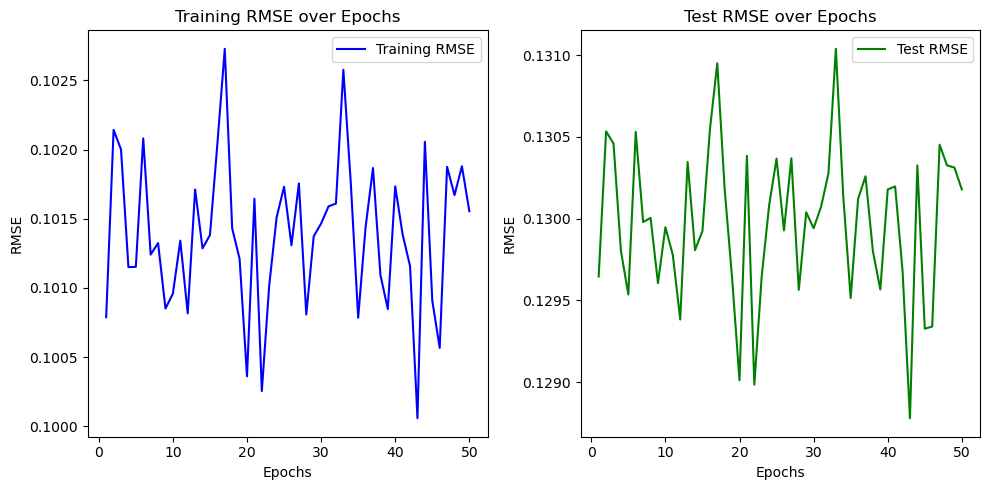

In [160]:
# Plotting the errors on separate graphs
epochs = np.arange(1, 51)

# Plot Training RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_errors, label='Training RMSE', color='blue')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training RMSE over Epochs')
plt.legend()

# Plot Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, test_errors, label='Test RMSE', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### Predicting Movie Ratings With SVD Model

In [216]:
# Example: Predict rating score for a specific user and movie
user_id = 1
movie_id = 50

# Predict the rating score using the trained SVD model
rating_prediction = svd.predict(user_id, movie_id)

# Round the predicted rating score to 2 decimal places
rounded_rating_prediction = round(rating_prediction.est, 2)

# Find the movie name corresponding to the movie ID
movie_title = svd_df.loc[svd_df['movieId'] == movie_id, 'title_name'].iloc[0]

# Print user ID, movie name, and rounded predicted rating score
print("User ID:", user_id)
print("Movie Name:", movie_title)
print("Predicted Rating Score:", rounded_rating_prediction)


User ID: 1
Movie Name: Usual Suspects, The
Predicted Rating Score: 4.37


- The model predicts that user ID 1 would rate the movie "The Usual Suspects" (movieId:50) 4.37. 

In [210]:
# Specify the user ID and movie ID for Toy Story
test_user_id = 136701
test_movie_id = 1

actual_rating = next((rating for u_id, m_id, rating in testset if u_id == test_user_id and m_id == test_movie_id), "Not Rated")

# Round the actual rating to 2 decimal points if it exists
rounded_actual_rating = round(actual_rating, 2) if actual_rating != "Not Rated" else "Not Rated"

# Predict the rating score using the trained SVD model
predicted_rating = svd.predict(test_user_id, test_movie_id).est
rounded_predicted_rating = round(predicted_rating, 2)  # Round to 2 decimal points

# Find the movie name corresponding to Toy Story's movie ID
test_movie_title = svd_df.loc[svd_df['movieId'] == test_movie_id, 'title_name'].iloc[0]

# Print the predicted and actual ratings
print("User ID:", test_user_id)
print("Movie Name:", test_movie_title)
print("Predicted Rating Score:", rounded_predicted_rating)
print("Actual Rating:", rounded_actual_rating)


User ID: 136701
Movie Name: Toy Story
Predicted Rating Score: 3.88
Actual Rating: 3.89


In [215]:
# Specify the user ID and movie ID for Mute
test_user_id = 155146
test_movie_id = 184017

actual_rating = next((rating for u_id, m_id, rating in testset if u_id == test_user_id and m_id == test_movie_id), "Not Rated")

# Round the actual rating to 2 decimal points if it exists
rounded_actual_rating = round(actual_rating, 2) if actual_rating != "Not Rated" else "Not Rated"

# Predict the rating score using the trained SVD model
predicted_rating = svd.predict(test_user_id, test_movie_id).est
rounded_predicted_rating = round(predicted_rating, 2)  # Round to 2 decimal points

# Find the movie name corresponding to Mute's movie ID
test_movie_title = svd_df.loc[svd_df['movieId'] == test_movie_id, 'title_name'].iloc[0]

# Print the predicted and actual ratings
print("User ID:", test_user_id)
print("Movie Name:", test_movie_title)
print("Predicted Rating Score:", rounded_predicted_rating)
print("Actual Rating:", rounded_actual_rating)


User ID: 155146
Movie Name: Mute
Predicted Rating Score: 2.82
Actual Rating: 2.77
